In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from math import ceil
import seaborn as sns
import plotly.express as px

In [36]:
#Define paths 

csv_path = os.path.abspath(
    os.path.join("..", "data", "processed", "05_-_Antioquia_2021_processed.csv")
)

geo_csv_path = os.path.abspath(
    os.path.join("..", "data", "external", "geo_refs.csv")
)

final_csv_path = os.path.abspath(
    os.path.join("..", "data", "processed", "Antioquia_2021_completed.csv")
)


In [37]:
# Read Csv
df = pd.read_csv(csv_path)
df.head()

,a_o,tipoatencion,numeroatenciones,codigo_departamento,nombre_departamento,codigo_municipio,nombre_municipio,codigo_diagnostico,n_diagnostico
0,2021,CONSULTAS,1,5,Antioquia,5501,Olaya,E02X,HIPOTIROIDISMO SUBCLINICO POR DEFICIENCIA DE YODO
1,2021,CONSULTAS,1,5,Antioquia,5501,Olaya,F069,TRASTORNO MENTAL NO ESPECIFICADO DEBIDO A LESI...
2,2021,CONSULTAS,1,5,Antioquia,5501,Olaya,F412,TRASTORNO MIXTO DE ANSIEDAD Y DEPRESION
3,2021,CONSULTAS,1,5,Antioquia,5501,Olaya,F510,INSOMNIO NO ORGANICO
4,2021,CONSULTAS,1,5,Antioquia,5501,Olaya,F529,"DISFUNCION SEXUAL, NO OCASIONADA POR TRASTORNO..."


In [38]:
print(df.shape)
df.info()

(278274, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278274 entries, 0 to 278273
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   a_o                  278274 non-null  int64 
 1   tipoatencion         278274 non-null  object
 2   numeroatenciones     278274 non-null  int64 
 3   codigo_departamento  278274 non-null  int64 
 4   nombre_departamento  278274 non-null  object
 5   codigo_municipio     278274 non-null  int64 
 6   nombre_municipio     278274 non-null  object
 7   codigo_diagnostico   278274 non-null  object
 8   n_diagnostico        278274 non-null  object
dtypes: int64(4), object(5)
memory usage: 19.1+ MB


In [39]:
print((df['codigo_municipio'].nunique()))

126


126 municipalities

In [40]:
print((df['codigo_diagnostico'].nunique()))

9489


9489 diagnoses codes

## Descriptive statistics


In [41]:
# Analyzing numeroatenciones

print(df[['numeroatenciones']].describe())
print(df[['numeroatenciones']].mode())


       numeroatenciones
count      2.782740e+05
mean       7.792001e+01
std        6.585246e+03
min        1.000000e+00
25%        1.000000e+00
50%        3.000000e+00
75%        9.000000e+00
max        3.252558e+06
   numeroatenciones
0                 1


The minimum number of medical services rendered is 1, while the highest is 3,252,558 for specific ICD-10 codes. Mode is 1.

In [42]:
min_value = df['numeroatenciones'].min()
resul_min = df[df['numeroatenciones'] == min_value].groupby('nombre_municipio')['numeroatenciones'].sum()
print(resul_min)


nombre_municipio
Abejorral      506
Abriaqui       148
Alejandria     302
Amaga          849
Amalfi         607
              ... 
Yali           705
Yarumal        131
Yolombo        575
Yondo          319
Zaragoza      1359
Name: numeroatenciones, Length: 126, dtype: int64


There are 126 municipalities that, for a specific ICD-10 code, have only one medical service rendered. For example, Zaragoza has 1,359 different ICD-10 codes that were recorded for only one patient during all of 2021.

In [43]:
max_value = df['numeroatenciones'].max()
result_max = df[df['numeroatenciones'] == max_value].groupby('nombre_municipio')['numeroatenciones'].sum()
print(result_max)


nombre_municipio
Medellin    3252558
Name: numeroatenciones, dtype: int64


Medellín has 3,252,558 records for a specific diagnosis code. This means that 3,252,558 people visited a doctor due to that particular condition (The same code)

In [44]:
result_max = df.groupby('nombre_municipio')['numeroatenciones'].sum().sort_values(ascending=True)
print(result_max)

nombre_municipio
Sin Informacion - Antioquia           3
San Andres De Cuerquia              259
Murindo                             834
Sabanalarga                        1420
Abriaqui                           1447
                                 ...   
Caucasia                         558324
Envigado                         727752
Itagui                          1272702
Bello                           1416674
Medellin                       10726430
Name: numeroatenciones, Length: 126, dtype: int64


Medellín has 10,726,430 records in total, the highest number of medical services rendered. In contrast, San Andrés de Cuerquia has only 259. Let's drop the records without municipality information ("Sin información - Antioquia").

In [45]:
df = df.drop(df[df['nombre_municipio'] == 'Sin Informacion - Antioquia'].index)
print(df.shape)

(278271, 9)


There is a significant difference between the minimum and maximum number of medical services rendered. This is expected due to the population differences among the municipalities.

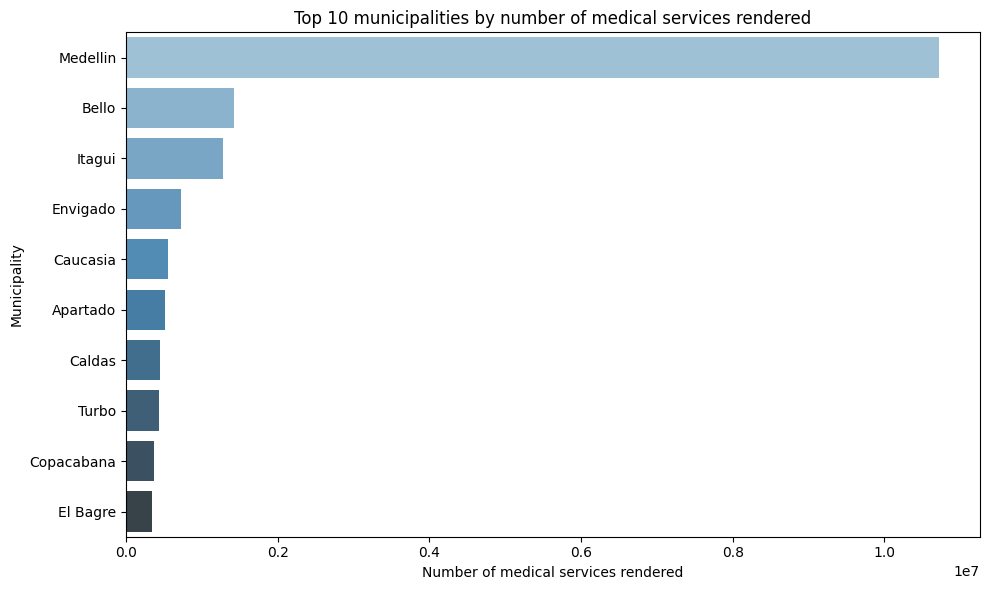

In [46]:
# Top 10 numeroatenciones/nombre_municipio 
municipios = df.groupby('nombre_municipio')['numeroatenciones'].sum().sort_values(ascending=False)
top_municipios = municipios.head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_municipios.values, y=top_municipios.index, palette='Blues_d')
plt.title('Top 10 municipalities by number of medical services rendered')
plt.xlabel('Number of medical services rendered')
plt.ylabel('Municipality')
plt.tight_layout()
plt.show()

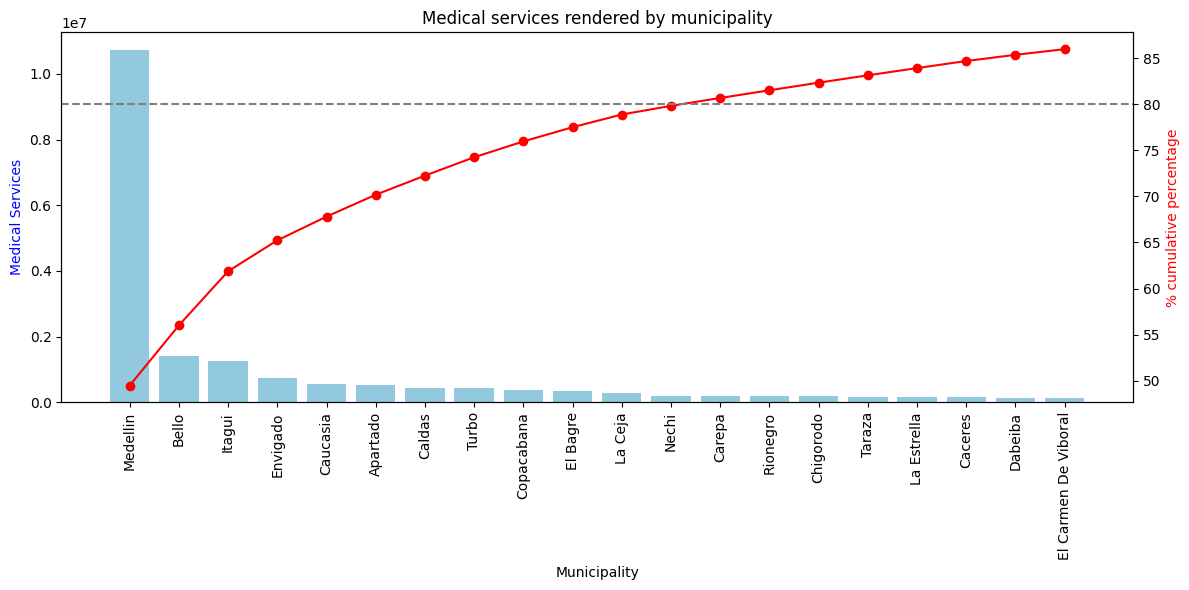

In [47]:
# Accumulate percentage
pareto = municipios.reset_index()
pareto.columns = ['Municipality', 'Atenciones']
pareto['% acumulado'] = pareto['Atenciones'].cumsum() / pareto['Atenciones'].sum() * 100

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(x='Municipality', y='Atenciones', data=pareto.head(20), ax=ax1, color='skyblue')
ax1.set_ylabel('Medical Services', color='blue')
ax1.tick_params(axis='x', rotation=90)

# Accumulate line
ax2 = ax1.twinx()
ax2.plot(pareto['Municipality'].head(20), pareto['% acumulado'].head(20), color='red', marker='o')
ax2.set_ylabel('% cumulative percentage', color='red')
ax2.axhline(80, color='gray', linestyle='--')

plt.title('Medical services rendered by municipality')
plt.tight_layout()
plt.show()


In [48]:
12*100/126

9.523809523809524

According to the Pareto chart, around 80% of the medical services are provided in just 10% of the municipalities.

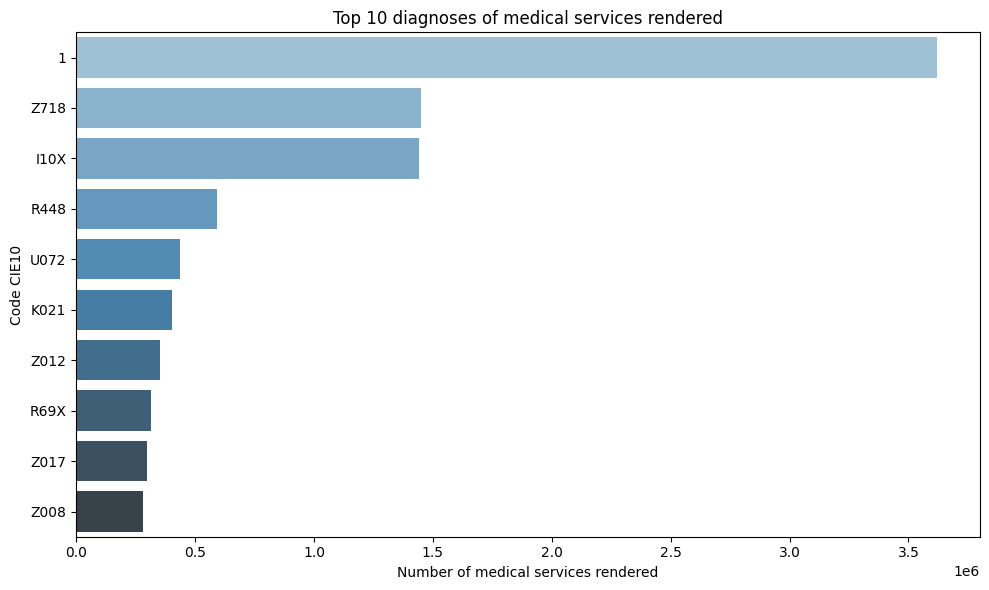

In [49]:
# Top 10 numeroatenciones/nombre_municipio 
diagnosticos = df.groupby('codigo_diagnostico')['numeroatenciones'].sum().sort_values(ascending=False)
top_diagnosticos = diagnosticos.head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_diagnosticos.values, y=top_diagnosticos.index, palette='Blues_d')
plt.title('Top 10 diagnoses of medical services rendered')
plt.xlabel('Number of medical services rendered')
plt.ylabel('Code CIE10')
plt.tight_layout()
plt.show()

In [50]:
print(df.loc[df['codigo_diagnostico'] == 'Z718', 'n_diagnostico'].iloc[0])
df.loc[df['codigo_diagnostico'] == 'Z718'].groupby('tipoatencion')['numeroatenciones'].count()


OTRAS CONSULTAS ESPECIFICADAS


tipoatencion
CONSULTAS                  87
PROCEDIMIENTOS DE SALUD    59
URGENCIAS                   7
Name: numeroatenciones, dtype: int64

In [51]:
print(df.loc[df['codigo_diagnostico'] == '1', 'n_diagnostico'].iloc[0])
df.loc[df['codigo_diagnostico'] == '1'].groupby('tipoatencion')['numeroatenciones'].count()


NO DEFINIDO


tipoatencion
PROCEDIMIENTOS DE SALUD    75
Name: numeroatenciones, dtype: int64

In [52]:
print(df.loc[df['codigo_diagnostico'] == 'I10X', 'n_diagnostico'].iloc[0])
df.loc[df['codigo_diagnostico'] == 'I10X'].groupby('tipoatencion')['numeroatenciones'].count()



HIPERTENSION ESENCIAL


tipoatencion
CONSULTAS                  83
HOSPITALIZACIONES          46
PROCEDIMIENTOS DE SALUD    73
URGENCIAS                  54
Name: numeroatenciones, dtype: int64

The most common diagnosis in Antioquia for 2021 in the dataset is "Not defined." This likely reflects missing or incomplete information and may not be useful for further analysis.

The second most frequent code is Z718 (Other specified medical consultations), which is used to classify situations in which an individual visits a healthcare provider to receive specific advice.

The type of medical service most commonly associated with Z718 is consultation, 87 records — a logical outcome given the nature of the code.

Finally, the third most frequent diagnosis in terms of medical services rendered is I10X (Essential hypertension).

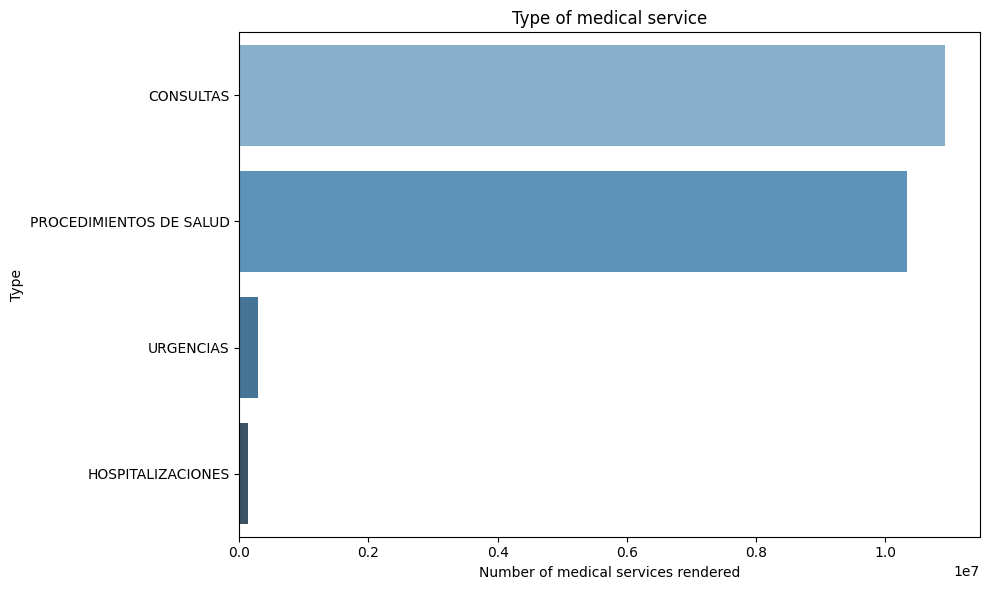

In [53]:
tipoatencion = df.groupby('tipoatencion')['numeroatenciones'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=tipoatencion.values, y=tipoatencion.index, palette='Blues_d')
plt.title('Type of medical service')
plt.xlabel('Number of medical services rendered')
plt.ylabel('Type')
plt.tight_layout()
plt.show()

In [54]:
df['tipoatencion'].value_counts(normalize=True)


CONSULTAS                  0.498859
PROCEDIMIENTOS DE SALUD    0.304469
URGENCIAS                  0.105458
HOSPITALIZACIONES          0.091213
Name: tipoatencion, dtype: float64

The most common type of medical service rendered in 2021 was consultations, accounting for nearly 50% of the data.

In [55]:
cie10_table = {
    'A': 'I - Enfermedades infecciosas y parasitarias',
    'B': 'I - Enfermedades infecciosas y parasitarias',
    'C': 'II - Neoplasias',
    'D': 'III - Enfermedades sangre / inmunidad',  
    'E': 'IV - Endocrinas, nutricionales y metabólicas',
    'F': 'V - Mentales y de comportamiento',
    'G': 'VI - Sistema nervioso',
    'H': 'VII-VIII - Ojo / Oreja',
    'I': 'IX - Sistema circulatorio',
    'J': 'X - Sistema respiratorio',
    'K': 'XI - Sistema digestivo',
    'L': 'XII - Piel y tejido subcutáneo',
    'M': 'XIII - Sistema musculoesquelético',
    'N': 'XIV - Aparato genitourinario',
    'O': 'XV - Embarazo y puerperio',
    'P': 'XVI - Perinatal',
    'Q': 'XVII - Malformaciones congénitas',
    'R': 'XVIII - Signos y síntomas',
    'S': 'XIX - Lesiones y otras causas externas',
    'T': 'XIX - Lesiones y otras causas externas',
    'V': 'XX - Causas externas de morbilidad y mortalidad',
    'W': 'XX - Causas externas de morbilidad y mortalidad',
    'X': 'XX - Causas externas de morbilidad y mortalidad',
    'Y': 'XXI - Causas externas de morbilidad y mortalidad',
    'Z': 'XXII - Factores sociales y contacto con salud',
}


In [56]:
df['capitulo'] = df['codigo_diagnostico'].str[0].map(cie10_table)
count_cie = df['capitulo'].value_counts().sort_values(ascending=True)
print(count_cie)


XXI - Causas externas de morbilidad y mortalidad     2141
XVI - Perinatal                                      3337
XX - Causas externas de morbilidad y mortalidad      4434
XVII - Malformaciones congénitas                     7050
VI - Sistema nervioso                                8972
X - Sistema respiratorio                            10003
I - Enfermedades infecciosas y parasitarias         10354
II - Neoplasias                                     10789
IV - Endocrinas, nutricionales y metabólicas        11274
III - Enfermedades sangre / inmunidad               11450
XII - Piel y tejido subcutáneo                      11756
V - Mentales y de comportamiento                    12979
XV - Embarazo y puerperio                           13002
IX - Sistema circulatorio                           14540
VII-VIII - Ojo / Oreja                              14777
XXII - Factores sociales y contacto con salud       16749
XVIII - Signos y síntomas                           16798
XIV - Aparato 

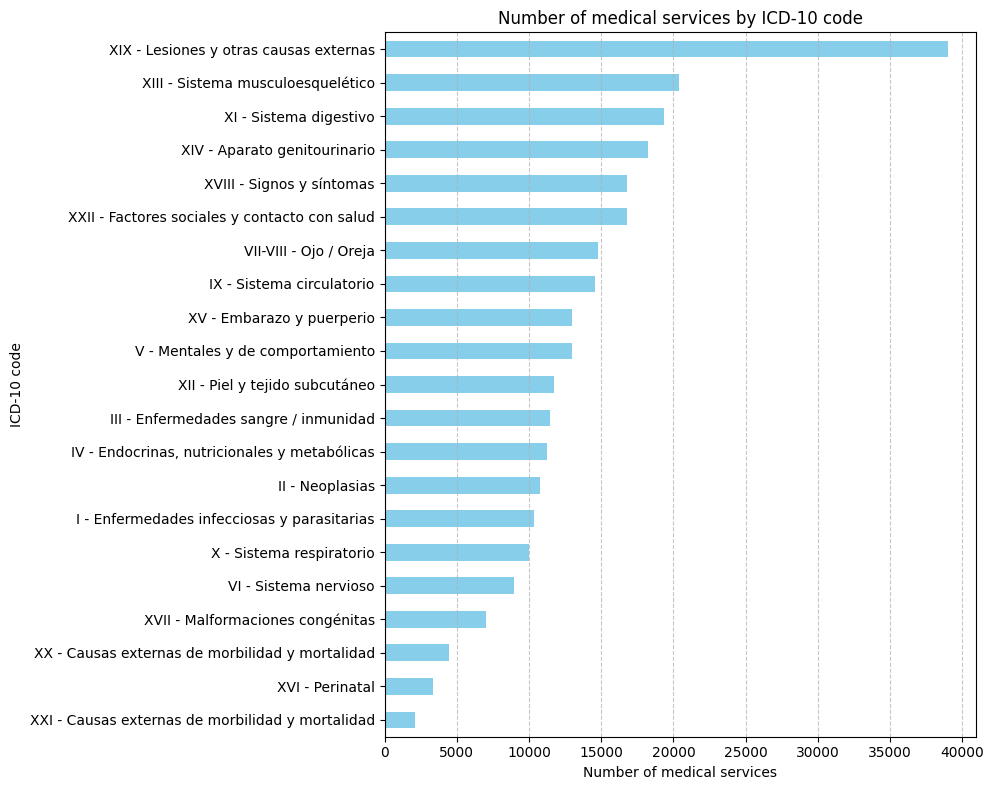

In [57]:
plt.figure(figsize=(10, 8))
count_cie.plot(kind='barh', color='skyblue')
plt.title('Number of medical services by ICD-10 code')
plt.xlabel('Number of medical services')
plt.ylabel('ICD-10 code') 
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Analyzing the ICD-10 codes more broadly, the data shows that the top three categories with the highest number of medical services correspond to injuries and other external causes, diseases of the musculoskeletal system, and diseases of the digestive system.

## Geographic Analysis 

In [58]:
# Read Csv with geographic info
df_geo = pd.read_csv(geo_csv_path)
df_geo.head()

,cod_dpto,nom_dpto,cod_mpio,nom_mpio,tipo,latitud,longitud,geo_municipio
0,5,ANTIOQUIA,5001,MEDELLÍN,Municipio,6.257590,-75.611031,"{'type': 'Point', 'coordinates': [-75.61103107..."
1,5,ANTIOQUIA,5002,ABEJORRAL,Municipio,5.803728,-75.438474,"{'type': 'Point', 'coordinates': [-75.43847353..."
2,5,ANTIOQUIA,5004,ABRIAQUÍ,Municipio,6.627569,-76.085978,"{'type': 'Point', 'coordinates': [-76.08597756..."
3,5,ANTIOQUIA,5021,ALEJANDRÍA,Municipio,6.365534,-75.090597,"{'type': 'Point', 'coordinates': [-75.09059702..."
4,5,ANTIOQUIA,5030,AMAGÁ,Municipio,6.032922,-75.708003,"{'type': 'Point', 'coordinates': [-75.7080031,..."


In [59]:
df_geo['cod_mpio'] = df_geo['cod_mpio'].astype(str).str.zfill(5)
df_geo.rename(columns={'cod_mpio': 'codigo_municipio'}, inplace=True)

df['codigo_municipio'] = df['codigo_municipio'].astype(str).str.zfill(5)

In [60]:
df_agg = df.groupby('codigo_municipio', as_index=False).agg({
    'numeroatenciones': 'sum'  
})
df_map = pd.merge(df_agg, df_geo, on='codigo_municipio', how='inner')
df_map.head()

,codigo_municipio,numeroatenciones,cod_dpto,nom_dpto,nom_mpio,tipo,latitud,longitud,geo_municipio
0,05001,10726430,5,ANTIOQUIA,MEDELLÍN,Municipio,6.257590,-75.611031,"{'type': 'Point', 'coordinates': [-75.61103107..."
1,05002,30516,5,ANTIOQUIA,ABEJORRAL,Municipio,5.803728,-75.438474,"{'type': 'Point', 'coordinates': [-75.43847353..."
2,05004,1447,5,ANTIOQUIA,ABRIAQUÍ,Municipio,6.627569,-76.085978,"{'type': 'Point', 'coordinates': [-76.08597756..."
3,05021,3273,5,ANTIOQUIA,ALEJANDRÍA,Municipio,6.365534,-75.090597,"{'type': 'Point', 'coordinates': [-75.09059702..."
4,05030,63585,5,ANTIOQUIA,AMAGÁ,Municipio,6.032922,-75.708003,"{'type': 'Point', 'coordinates': [-75.7080031,..."


In [61]:
min_size = 15
max_size = 50

df_map["size_normalized"] = df_map["numeroatenciones"].apply(
    lambda x: min_size + (max_size - min_size) * (x - df_map["numeroatenciones"].min()) / (df_map["numeroatenciones"].max() - df_map["numeroatenciones"].min())
)

fig = px.scatter_mapbox(
    df_map,
    lat="latitud",
    lon="longitud",
    size="size_normalized",
    hover_name="nom_mpio",
    hover_data=["numeroatenciones"],
    color="numeroatenciones",
    color_continuous_scale="spectral",
    zoom=6.2,
    height=600,
    mapbox_style="carto-positron",
    title="Medical services by Municipality (Normalized)"
)
fig.show()


The map shows a concentration of medical services rendered in the central zone of the Antioquia department, which is expected since this area has the highest population. The number of medical services rendered decreases in zones located near the borders with other Colombian departments.

Medellín reported 10,756,430 medical services rendered, while one of the municipalities with the lowest number of services is San Andres De Cuerquia, with only 259 records.

## Organizing the CSV for further analysis

In [62]:
df_geo = df_geo[['codigo_municipio', 'latitud', 'longitud']]

In [63]:
df_merged = pd.merge(df, df_geo, on='codigo_municipio', how='left')


In [64]:
df_merged.to_csv(final_csv_path, index=False, encoding='utf-8')
print(f"\n✅ Processed file saved at:\n{final_csv_path}")


✅ Processed file saved at:
/home/ym0r4l3s/projects/RIPS_Project/rips_project/data/processed/Antioquia_2021_completed.csv
